# Equity Analyst Agent with Assistants API

### This notebook showcases the capabilities of Azure OpenAI's Assistants API for an Equity Analyst Agent. 

Install the necessary Python packages (openai, matplotlib, tenacity, python-dotenv) for the notebook to function.

In [ ]:
%pip install openai matplotlib tenacity python-dotenv

Imports the necessary Python modules and classes used in the notebook. Note the openai module is used to interact with the Assistants API.

In [2]:
import os
from pathlib import Path
from dotenv import load_dotenv
from openai import AzureOpenAI
from tenacity import RetryError

from azure_ai_util import AzureAIUtils, NotCompletedException

### Initializing Azure OpenAI Client
This cell crucial for establishing communication with Azure OpenAI services. 

- **Requirement**: Ensure that a `.env` file exists in the same directory as this notebook. This file should contain the necessary API credentials and configuration details, which you can obtain from https://ai.azure.com 
- **Keys in .env File**: The `.env` file must include the following keys:
  - `OPENAI_ENDPOINT`: The endpoint URL for the Azure OpenAI service.
  - `OPENAI_API_KEY`: Your API key for accessing Azure OpenAI services.

Initializes `AzureOpenAI` client with necessary credentials and configurations:
- `api_key`: API key for authentication.
- `api_version`: Targeted API version, set to `"2024-02-15-preview"`.
- `azure_endpoint`: Endpoint URL for Azure OpenAI services.

In [3]:
load_dotenv(".env")
client = AzureOpenAI(api_key=os.getenv("OPENAI_API_KEY"), 
                     azure_endpoint=os.getenv("OPENAI_ENDPOINT"),
                     api_version="2024-02-15-preview")

utils = AzureAIUtils(client)

### Create the assistant with tools and files

![How Assistants work](./images/assistants.png)


The `create_assistant` function creates an assistant with tools and files. The function takes the following parameters:
- `name`: The name of the assistant.
- `instructions`: The system message (or meta prompt) that gives the assistant a persona and context.
- `tools`: A list of tools that the assistant can use to perform tasks. Currently, these are `code_intrepreter` and `retriever`.
- `functions`: Custom functions that the assistant can use to perform tasks. Similar to function calling feature.
- `model`: The name of the model to use for the assistant.

In [4]:
# Fetch the files under the datasets directory
DATASETS = "datasets/"

assistant_files = [utils.upload_file(Path(DATASETS) / file) for file in os.listdir(DATASETS)]
file_ids = [file.id for file in assistant_files]

Create the assistant with tools and files

In [5]:
assistant = client.beta.assistants.create(
    name="Equity Analyst",
    instructions=("You are an equity analyst that performs analysis on the given datasets. "
                  "Use the provided file only."),
    tools=[{"type": "code_interpreter"}],
    file_ids=file_ids,
    model=os.getenv("OPENAI_MODEL_NAME")
)

Create a thread, which represents a conversation. It is recommended to create one thread per user. 

In [6]:
thread = client.beta.threads.create()

Create a thread run

![Run lifecycle](https://cdn.openai.com/API/docs/images/diagram-1.png)

In [7]:
def analyst_assistant(content: str):
    client.beta.threads.messages.create(thread_id=thread.id, role="user", content=content)

    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions=f"You are a equity analyst who maps out the ask of the user to an equity analyst's task and thinks step by step to analyze, including making use of the tools. Make generic assumptions",
    )

    try:
        run = utils.get_run_lifecycle_status(thread.id, run.id)
        messages = client.beta.threads.messages.list(thread_id=thread.id)
        utils.format_response(messages)
    except RetryError:
        print("Operation failed or timed out after maximum retries.")
    except NotCompletedException:
        print("Operation did not complete in the expected status.")


### Have the assistant perform a DCF valuation

Run status: queued
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: completed
Run info: Run(id='run_vrqJm1WPDt5ExvvHmoLwHtlx', assistant_id='asst_EVTjx4hPjZ0IBrEG7oGjtdLS', cancelled_at=None, completed_at=1707617874, created_at=1707617792, expires_at=None, failed_at=None, file_ids=['assistant-6YtpAiT2SdzcLPGqfCd1zCcu'], instructions="You are a equity analyst who maps out the ask of the user to an equity analyst's task and thinks step by step to analyze, including making use of the tools. Make generic assumptions", last_error=None, metadata={}, model='gpt-4', object='thread.run', required_action=None, started_at=1707617793, status='completed', thread_id='thread_KVRmHgZcBSn2MFL00yH2sHv8', tools=[ToolAssistantToolsCode(type='code_interpreter')], usage=None)
user:
Visualize the data and provide insights on the trends.

assistant:
To provide you with insights on the trends through visu

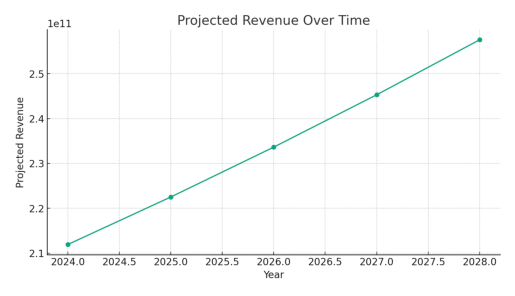

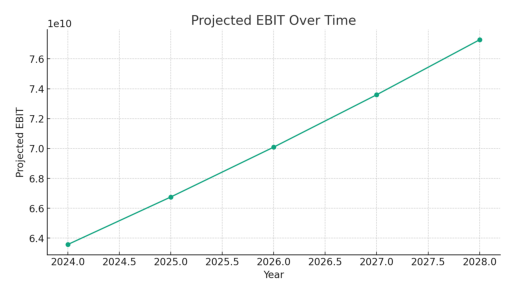

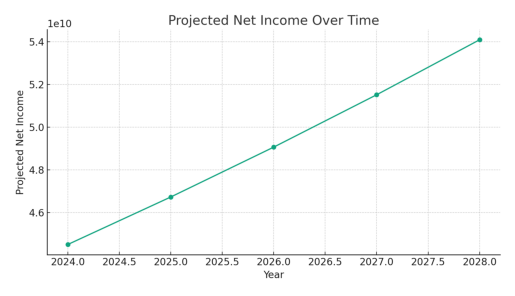

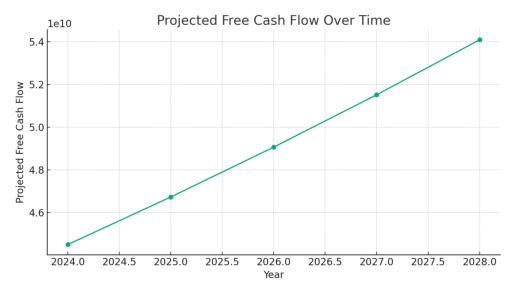

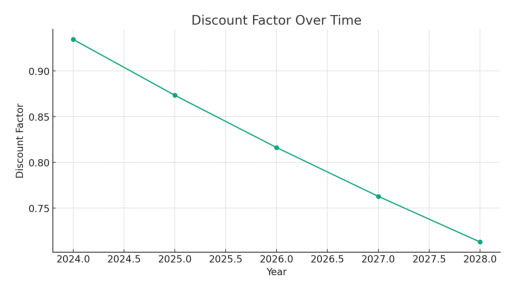

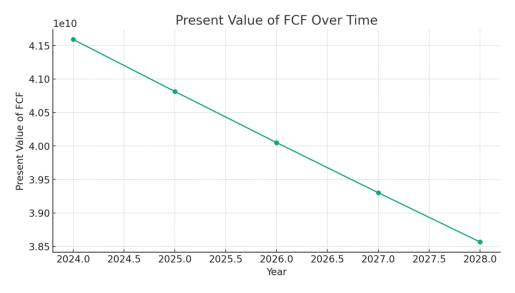

assistant:
The visualizations for the various financial metrics over the projected years have been created. Here are some insights based on the trends seen in the charts:

1. **Projected Revenue Over Time:** There is a consistent upward trend in projected revenue year over year, indicating expected growth in the company's top-line performance.

2. **Projected EBIT Over Time:** Similarly, the Earnings Before Interest and Taxes (EBIT) also shows a rising trend, which hints at healthy growth in operational profitability before accounting for interest and taxes.

3. **Projected Net Income Over Time:** The net income, which factors in taxes and interest, continues the upward trend. This is a positive sign for the company's bottom-line growth.

4. **Projected Free Cash Flow Over Time:** The free cash flow, which is the cash generated by the company after accounting for capital expenditures, displays growth year over year. This suggests that the company is projected to have more cash availabl

In [8]:
analyst_assistant("Visualize the data and provide insights on the trends.")

In [9]:
analyst_assistant("Perform a discounted cash flow valuation using the provided dataset, and print the code along with its executed output that was used for this calculation.")

Run status: queued
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: completed
Run info: Run(id='run_LlT56mitw9rQc6o2HPk4mIJJ', assistant_id='asst_EVTjx4hPjZ0IBrEG7oGjtdLS', cancelled_at=None, completed_at=1707617937, created_at=1707617905, expires_at=None, failed_at=None, file_ids=['assistant-6YtpAiT2SdzcLPGqfCd1zCcu'], instructions="You are a equity analyst who maps out the ask of the user to an equity analyst's task and thinks step by step to analyze, including making use of the tools. Make generic assumptions", last_error=None, metadata={}, model='gpt-4', object='thread.run', required_action=None, started_at=1707617906, status='completed', thread_id='thread_KVRmHgZcBSn2MFL00yH2sHv8', tools=[ToolAssistantToolsCode(type='code_interpreter')], usage=None)
user:
Perform a discounted cash flow valuation using the provided dataset, and print the code along with its executed output that was used for this calculation.

assistant:
To 

Run status: queued
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: completed
Run info: Run(id='run_0xCw8vKutDdwkVaaLxfJgVbR', assistant_id='asst_EVTjx4hPjZ0IBrEG7oGjtdLS', cancelled_at=None, completed_at=1707618041, created_at=1707617988, expires_at=None, failed_at=None, file_ids=['assistant-6YtpAiT2SdzcLPGqfCd1zCcu'], instructions="You are a equity analyst who maps out the ask of the user to an equity analyst's task and thinks step by step to analyze, including making use of the tools. Make generic assumptions", last_error=None, metadata={}, model='gpt-4', object='thread.run', required_action=None, started_at=1707617989, status='completed', thread_id='thread_KVRmHgZcBSn2MFL00yH2sHv8', tools=[ToolAssistantToolsCode(type='code_interpreter')], usage=None)
user:
Summarize and Visualize this information to someone new to finance and investing.

assistant:
Sure, to explain this to someone new to finance and 

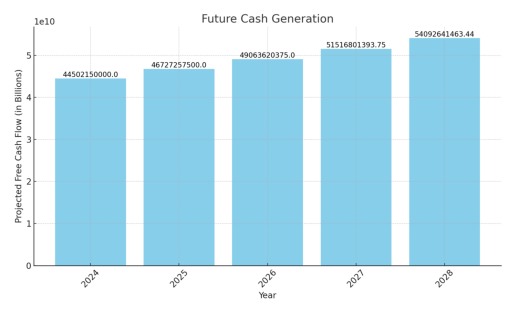

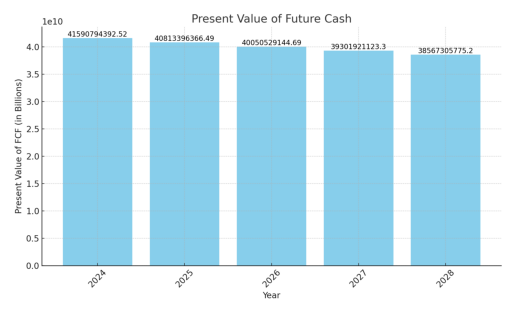

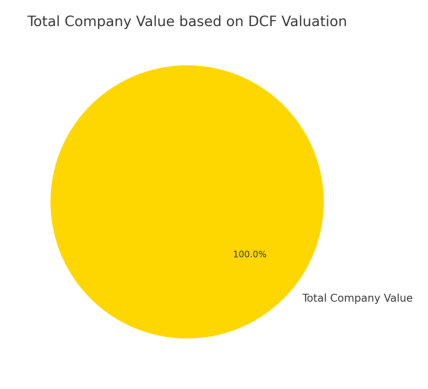

assistant:
Here are visuals that help explain the discounted cash flow (DCF) valuation to someone new to finance and investing:

1. **Future Cash Generation:** This bar chart shows the projected money the company is expected to generate each year in the future, also known as Free Cash Flow (FCF). As you move to the right, you can see the growth in cash generation each year.

2. **Present Value of Future Cash:** The second bar chart adjusts the future cash flows to their value in today's terms, accounting for the concept that money in the future is worth less than money today. These bars appear shorter because of the discount applied.

3. **Total Company Value:** The pie chart represents the total value of the company based on adding up all the present values of future cash flows. It shows what the company is worth today, based on the money it is expected to generate in the future.

The DCF valuation calculated from the provided projections is around $200.32 billion. 

To a new investor

In [10]:
analyst_assistant("Summarize and Visualize this information to someone new to finance and investing.")

### Delete the thread and assistant

In [ ]:
for entity in [(client.beta.assistants, assistant), (client.beta.threads, thread)]:
    entity[0].delete(entity[1].id)

for file in assistant_files:
    client.files.delete(file.id)